# SigLIP - PneumoniaMNIST Binary Classification (Fixed)

**Dataset:** PneumoniaMNIST (MedMNIST) — Normal vs Pneumonia (binary)
**Model:** google/siglip-base-patch16-224 — vision encoder ONLY (no OOM crash)
**Freeze:** first 50 named param tensors frozen, last ~50% trainable
**Fixes:** SiglipVisionModel only / batch=8 + grad accum / new autocast API / empty_cache after load


In [ ]:
!pip install transformers>=4.38
!pip install medmnist          # only needed for PneumoniaMNIST
!pip install torchinfo         # optional — for model summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.6 MB/s eta 0:00:00


In [ ]:
import os, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T

try:
    import transformers
    print(f"Transformers : {transformers.__version__}")
except ImportError:
    os.system("pip install -q transformers>=4.38")
    import transformers

from transformers import SiglipVisionModel, SiglipProcessor

# Install medmnist if needed
try:
    import medmnist
    print(f"MedMNIST     : {medmnist.__version__}")
except ImportError:
    os.system("pip install -q medmnist")
    import medmnist

from medmnist import PneumoniaMNIST
from medmnist import INFO

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score,
    f1_score, precision_score, recall_score,
)
from sklearn.preprocessing import label_binarize

print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")
    print(f"VRAM    : {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")


Transformers : 5.0.0
MedMNIST     : 3.0.2
PyTorch : 2.10.0+cu128
CUDA    : True
GPU     : Tesla T4
VRAM    : 15.6 GB


In [ ]:
class Config:
    DATA_DIR   = "/kaggle/working/medmnist"   # download cache
    OUTPUT_DIR = "/kaggle/working"

    CHECKPOINT     = "google/siglip-base-patch16-224"
    NUM_CLASSES    = 2
    CLASS_NAMES    = ["Normal", "Pneumonia"]
    SHORT_NAMES    = ["Normal", "Pneumonia"]
    FREEZE_FIRST_N = 50

    BATCH_SIZE    = 8
    GRAD_ACCUM    = 2           # effective batch = 16
    NUM_EPOCHS    = 15
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY  = 1e-5
    IMG_SIZE      = 224         # SigLIP native resolution

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED   = 42

cfg = Config()
os.makedirs(cfg.DATA_DIR, exist_ok=True)

def set_seed(s):
    np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"Device  : {cfg.DEVICE}")
print(f"Model   : {cfg.CHECKPOINT}")
print(f"Classes : {cfg.CLASS_NAMES}")


Device  : cuda
Model   : google/siglip-base-patch16-224
Classes : ['Normal', 'Pneumonia']


## Data Exploration

Task      : binary-class
n_channels: 1
n_samples : {'train': 4708, 'val': 524, 'test': 624}
Labels    : {'0': 'normal', '1': 'pneumonia'}


100%|██████████| 214M/214M [00:19<00:00, 11.2MB/s]


Native download size: 224x224
  Train  — Normal: 1214  Pneumonia: 3494  Total: 4708
  Val    — Normal: 135  Pneumonia: 389  Total: 524
  Test   — Normal: 234  Pneumonia: 390  Total: 624


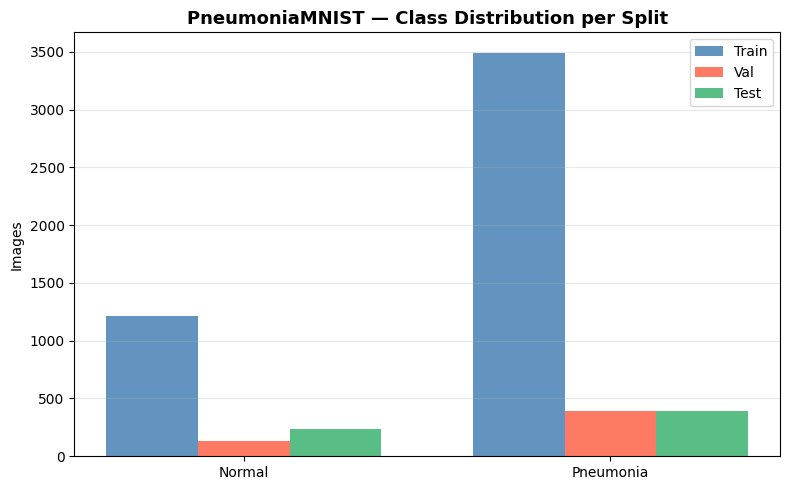

In [ ]:
# PneumoniaMNIST info
info = INFO["pneumoniamnist"]
print("Task      :", info["task"])
print("n_channels:", info["n_channels"])
print("n_samples :", info["n_samples"])
print("Labels    :", info["label"])

# Download splits (28x28 greyscale, we will resize to 224 in the dataset class)
# size=224 is available in newer medmnist; fall back to default 28 and resize manually
try:
    _tmp = PneumoniaMNIST(split="train", download=True, size=224, root=cfg.DATA_DIR)
    NATIVE_SIZE = 224
except Exception:
    _tmp = PneumoniaMNIST(split="train", download=True, root=cfg.DATA_DIR)
    NATIVE_SIZE = 28

print(f"Native download size: {NATIVE_SIZE}x{NATIVE_SIZE}")
del _tmp

# Count class distribution per split
from collections import Counter

split_counts = {}
for split in ["train", "val", "test"]:
    try:
        ds = PneumoniaMNIST(split=split, download=True, size=NATIVE_SIZE, root=cfg.DATA_DIR)
    except Exception:
        ds = PneumoniaMNIST(split=split, download=True, root=cfg.DATA_DIR)
    labels_flat = [int(ds.labels[i][0]) for i in range(len(ds))]
    cnt = Counter(labels_flat)
    split_counts[split.capitalize()] = [cnt.get(0, 0), cnt.get(1, 0)]
    print(f"  {split.capitalize():6s} — Normal: {cnt.get(0,0)}  Pneumonia: {cnt.get(1,0)}  Total: {len(ds)}")

# Bar chart — same style as lung cancer notebook
x = np.arange(len(cfg.SHORT_NAMES)); w = 0.25
clrs = ["steelblue", "tomato", "mediumseagreen"]
fig, ax = plt.subplots(figsize=(8, 5))
for i, (split, color) in enumerate(zip(["Train", "Val", "Test"], clrs)):
    ax.bar(x + i*w, split_counts[split], w, label=split, color=color, alpha=0.85)
ax.set_xticks(x + w); ax.set_xticklabels(cfg.SHORT_NAMES)
ax.set_ylabel("Images"); ax.set_title("PneumoniaMNIST — Class Distribution per Split", fontsize=13, fontweight="bold")
ax.legend(); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_pm_class_distribution.png"), dpi=150, bbox_inches="tight")
plt.show()


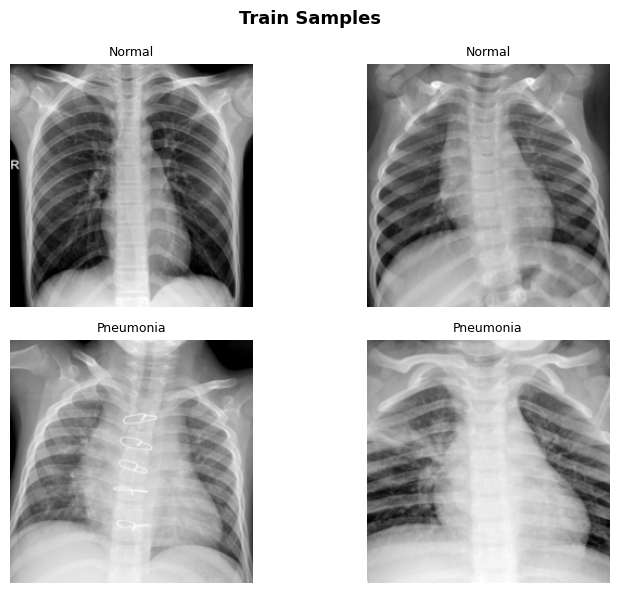

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.06MB/s]


ValueError: 

In [ ]:
# Sample image grid — 2 images per class per split (mirrors lung cancer notebook)
def show_sample_grid_medmnist(split_name, n=2):
    try:
        ds = PneumoniaMNIST(split=split_name.lower(), download=True, size=NATIVE_SIZE, root=cfg.DATA_DIR)
    except Exception:
        ds = PneumoniaMNIST(split=split_name.lower(), download=True, root=cfg.DATA_DIR)

    # Collect n samples per class
    class_indices = {0: [], 1: []}
    for i in range(len(ds)):
        lbl = int(ds.labels[i][0])
        if len(class_indices[lbl]) < n:
            class_indices[lbl].append(i)

    fig, axes = plt.subplots(cfg.NUM_CLASSES, n, figsize=(n*4, cfg.NUM_CLASSES*3))
    fig.suptitle(f"{split_name} Samples", fontsize=13, fontweight="bold")
    for row, (cls_idx, idxs) in enumerate(class_indices.items()):
        for col, img_idx in enumerate(idxs):
            img_arr, _ = ds[img_idx]
            # img_arr is a PIL Image from medmnist
            ax = axes[row, col]
            ax.imshow(img_arr, cmap="gray")
            ax.set_title(cfg.CLASS_NAMES[cls_idx], fontsize=9)
            ax.axis("off")
    plt.tight_layout()
    slug = split_name.lower().replace(" ", "_")
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, f"siglip_pm_samples_{slug}.png"), dpi=120, bbox_inches="tight")
    plt.show()

show_sample_grid_medmnist("Train")
show_sample_grid_medmnist("Validation", )
show_sample_grid_medmnist("Test")


## Dataset & DataLoaders

In [ ]:
print("Loading SigLIP processor ...")
processor = SiglipProcessor.from_pretrained(cfg.CHECKPOINT)
print("Processor ready.")

# No augmentation on train — only resize (via processor) is needed.
# PneumoniaMNIST images are 28x28 greyscale; processor resizes to 224x224
# and handles normalization internally.

class PneumoniaMNISTDataset(Dataset):
    """
    Wraps MedMNIST PneumoniaMNIST split.
    Converts greyscale PIL → RGB (replicate channel) so SigLIP sees 3-channel input.
    No augmentation — only the resize + normalisation the SigLIP processor applies.
    """
    def __init__(self, split):
        try:
            self.base = PneumoniaMNIST(split=split, download=True,
                                       size=NATIVE_SIZE, root=cfg.DATA_DIR)
        except Exception:
            self.base = PneumoniaMNIST(split=split, download=True, root=cfg.DATA_DIR)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label_arr = self.base[idx]
        label = int(label_arr[0])
        # medmnist returns PIL Images; ensure RGB for SigLIP
        if isinstance(img, Image.Image):
            img = img.convert("RGB")
        else:
            img = Image.fromarray(np.array(img)).convert("RGB")
        pv = processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        return pv, label

train_ds = PneumoniaMNISTDataset("train")
val_ds   = PneumoniaMNISTDataset("val")
test_ds  = PneumoniaMNISTDataset("test")

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train:{len(train_ds)}  Val:{len(val_ds)}  Test:{len(test_ds)}")


Loading SigLIP processor ...


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

The image processor of type `SiglipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Processor ready.
Train:4708  Val:524  Test:624


## Model

In [ ]:
class SigLIPClassifier(nn.Module):
    # Uses SiglipVisionModel ONLY — never loads text encoder -> no OOM
    # Freeze first `freeze_first_n` param tensors, train the rest (~50%)
    def __init__(self, checkpoint, num_classes, freeze_first_n=50):
        super().__init__()
        print(f"Loading SiglipVisionModel from '{checkpoint}' ...")
        self.encoder = SiglipVisionModel.from_pretrained(checkpoint)
        hidden = self.encoder.config.hidden_size
        print(f"Hidden size : {hidden}")

        params = list(self.encoder.named_parameters())
        total  = len(params)
        print(f"Named param tensors : {total}  |  freezing first {freeze_first_n}")
        for i, (_, p) in enumerate(params):
            p.requires_grad = (i >= freeze_first_n)

        tr = sum(p.numel() for p in self.encoder.parameters() if p.requires_grad)
        tt = sum(p.numel() for p in self.encoder.parameters())
        print(f"Encoder trainable : {tr:,} / {tt:,}  ({100*tr/tt:.1f} %)")

        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, pixel_values):
        out = self.encoder(pixel_values=pixel_values)
        return self.head(out.pooler_output)

model = SigLIPClassifier(cfg.CHECKPOINT, cfg.NUM_CLASSES, cfg.FREEZE_FIRST_N).to(cfg.DEVICE)
gc.collect(); torch.cuda.empty_cache()
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params     : {total_p:,}")
print(f"Trainable params : {train_p:,}  ({100*train_p/total_p:.1f}%)")


Loading SiglipVisionModel from 'google/siglip-base-patch16-224' ...


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SiglipVisionModel LOAD REPORT from: google/siglip-base-patch16-224
Key                                                          | Status     |  | 
-------------------------------------------------------------+------------+--+-
text_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.out_proj.bias   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.k_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm2.weight        | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.mlp.fc2.bias              | UNEXPECTED |  | 
text_model.encoder.layers.{0...11}.layer_norm2.bias          | UNEXPECTED |  | 
logit_bias                                           

Hidden size : 768
Named param tensors : 208  |  freezing first 50
Encoder trainable : 70,880,256 / 92,884,224  (76.3 %)
Total params     : 93,278,978
Trainable params : 71,275,010  (76.4%)


## Loss / Optimizer / Scheduler

In [ ]:
# Class-weighted CrossEntropy to handle any imbalance
train_labels_all = [int(train_ds.base.labels[i][0]) for i in range(len(train_ds))]
counts  = np.bincount(train_labels_all, minlength=cfg.NUM_CLASSES).astype(float)
weights = torch.tensor(1.0 / (counts + 1e-6), dtype=torch.float32)
weights = (weights / weights.sum() * cfg.NUM_CLASSES).to(cfg.DEVICE)
print("Class weights:", weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW([
    {"params": [p for p in model.encoder.parameters() if p.requires_grad],
     "lr": cfg.LEARNING_RATE},
    {"params": model.head.parameters(), "lr": cfg.LEARNING_RATE * 10},
], weight_decay=cfg.WEIGHT_DECAY)

scheduler = CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS, eta_min=1e-7)
print(f"Backbone LR={cfg.LEARNING_RATE}  Head LR={cfg.LEARNING_RATE*10}")


Class weights: [1.484282  0.5157179]
Backbone LR=5e-05  Head LR=0.0005


## Training Loop

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, accum):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    optimizer.zero_grad()
    for step, (pv, labels) in enumerate(tqdm(loader, desc="Train", leave=False)):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels) / accum
        scaler.scale(loss).backward()
        if (step + 1) % accum == 0 or (step + 1) == len(loader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
        running_loss += loss.item() * accum * pv.size(0)
        correct      += (logits.argmax(1) == labels).sum().item()
        total        += pv.size(0)
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_probs, all_preds, all_labels = [], [], []
    for pv, labels in tqdm(loader, desc="Eval ", leave=False):
        pv, labels = pv.to(device), labels.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(pv)
            loss   = criterion(logits, labels)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(1)
        running_loss += loss.item() * pv.size(0)
        correct      += (preds == labels).sum().item()
        total        += pv.size(0)
        all_probs.append(probs.cpu()); all_preds.append(preds.cpu()); all_labels.append(labels.cpu())
    return (running_loss / total, correct / total,
            torch.cat(all_probs).numpy(),
            torch.cat(all_preds).numpy(),
            torch.cat(all_labels).numpy())


In [ ]:
scaler = torch.amp.GradScaler("cuda", enabled=(cfg.DEVICE.type == "cuda"))

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss   = float("inf")
best_model_path = os.path.join(cfg.OUTPUT_DIR, "siglip_pm_best.pth")

for epoch in range(1, cfg.NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, cfg.DEVICE, scaler, cfg.GRAD_ACCUM)
    va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, cfg.DEVICE)
    scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    tag = "  <- saved" if va_loss < best_val_loss else ""
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model.state_dict(), best_model_path)
    print(f"Epoch [{epoch:02d}/{cfg.NUM_EPOCHS}]  "
          f"Train Loss={tr_loss:.4f} Acc={tr_acc:.4f}  |  "
          f"Val Loss={va_loss:.4f} Acc={va_acc:.4f}{tag}")

print(f"\nBest val loss: {best_val_loss:.4f}")


Epoch [01/15]  Train Loss=0.2552 Acc=0.9378  |  Val Loss=0.0616 Acc=0.9885  <- saved


Epoch [02/15]  Train Loss=0.1051 Acc=0.9826  |  Val Loss=0.0459 Acc=0.9905  <- saved


Epoch [03/15]  Train Loss=0.0703 Acc=0.9917  |  Val Loss=0.0651 Acc=0.9828


Epoch [04/15]  Train Loss=0.0307 Acc=0.9934  |  Val Loss=0.0228 Acc=0.9962  <- saved


Epoch [05/15]  Train Loss=0.0357 Acc=0.9941  |  Val Loss=0.0277 Acc=0.9962


Epoch [06/15]  Train Loss=0.0144 Acc=0.9977  |  Val Loss=0.0798 Acc=0.9885


Epoch [07/15]  Train Loss=0.0023 Acc=0.9996  |  Val Loss=0.1338 Acc=0.9809


Epoch [08/15]  Train Loss=0.0027 Acc=0.9994  |  Val Loss=0.1977 Acc=0.9828


Epoch [09/15]  Train Loss=0.0029 Acc=0.9994  |  Val Loss=0.0591 Acc=0.9924


Epoch [10/15]  Train Loss=0.0012 Acc=0.9996  |  Val Loss=0.0555 Acc=0.9924


Epoch [11/15]  Train Loss=0.0000 Acc=1.0000  |  Val Loss=0.0549 Acc=0.9924


Epoch [12/15]  Train Loss=0.0000 Acc=1.0000  |  Val Loss=0.0547 Acc=0.9924


Epoch [13/15]  Train Loss=0.0000 Acc=1.0000  |  Val Loss=0.0542 Acc=0.9924


Epoch [14/15]  Train Loss=0.0000 Acc=1.0000  |  Val Loss=0.0540 Acc=0.9924


Epoch [15/15]  Train Loss=0.0000 Acc=1.0000  |  Val Loss=0.0541 Acc=0.9924

Best val loss: 0.0228


In [ ]:
model.load_state_dict(torch.load(best_model_path, map_location=cfg.DEVICE))
print("Loaded best checkpoint.")
_, val_acc, val_probs, val_preds, val_labels = evaluate(model, val_loader,  criterion, cfg.DEVICE)
_, tst_acc, tst_probs, tst_preds, tst_labels = evaluate(model, test_loader, criterion, cfg.DEVICE)
print(f"Val  Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {tst_acc:.4f}")


Loaded best checkpoint.


Val  Accuracy: 0.9962
Test Accuracy: 0.8590


## Training Curves

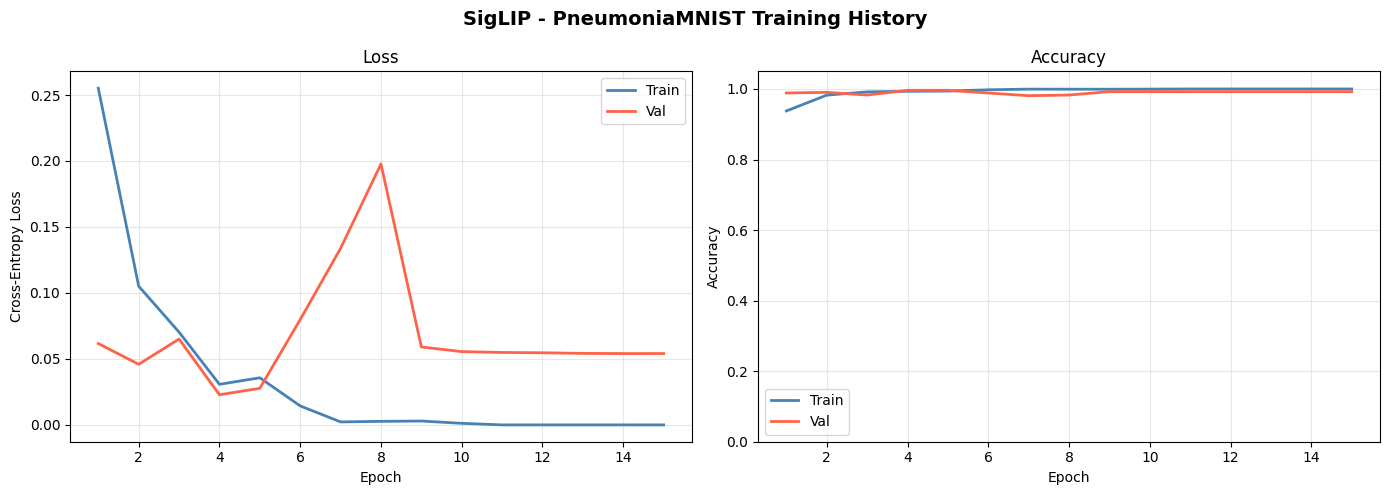

In [ ]:
ep = range(1, cfg.NUM_EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("SigLIP - PneumoniaMNIST Training History", fontsize=14, fontweight="bold")
axes[0].plot(ep, history["train_loss"], label="Train", color="steelblue", lw=2)
axes[0].plot(ep, history["val_loss"],   label="Val",   color="tomato",    lw=2)
axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].plot(ep, history["train_acc"], label="Train", color="steelblue", lw=2)
axes[1].plot(ep, history["val_acc"],   label="Val",   color="tomato",    lw=2)
axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1.05); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_pm_training_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Classification Reports

In [ ]:
reports = []
for split_name, preds, labels in [("Validation", val_preds, val_labels),
                                   ("Test",       tst_preds, tst_labels)]:
    print(f"\n{'='*60}\n  {split_name} Report\n{'='*60}")
    print(classification_report(labels, preds, target_names=cfg.CLASS_NAMES))
    for i, cls in enumerate(cfg.CLASS_NAMES):
        b_true = (labels == i).astype(int)
        b_pred = (preds  == i).astype(int)
        reports.append({
            "Split": split_name, "Class": cls,
            "Accuracy":  accuracy_score(b_true, b_pred),
            "Precision": precision_score(b_true, b_pred, zero_division=0),
            "Recall":    recall_score(b_true, b_pred, zero_division=0),
            "F1-Score":  f1_score(b_true, b_pred, zero_division=0),
        })

reports_df = pd.DataFrame(reports)
reports_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "siglip_pm_reports.csv"), index=False)
print(reports_df.to_string(index=False))



  Validation Report
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       135
   Pneumonia       1.00      0.99      1.00       389

    accuracy                           1.00       524
   macro avg       0.99      1.00      1.00       524
weighted avg       1.00      1.00      1.00       524


  Test Report
              precision    recall  f1-score   support

      Normal       0.99      0.63      0.77       234
   Pneumonia       0.82      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.91      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624

     Split     Class  Accuracy  Precision   Recall  F1-Score
Validation    Normal  0.996183   0.985401 1.000000  0.992647
Validation Pneumonia  0.996183   1.000000 0.994859  0.997423
      Test    Normal  0.858974   0.993243 0.628205  0.769634
      Test Pneumonia  0.858974   0.817227 0.997436  0.898383


## ROC Curves

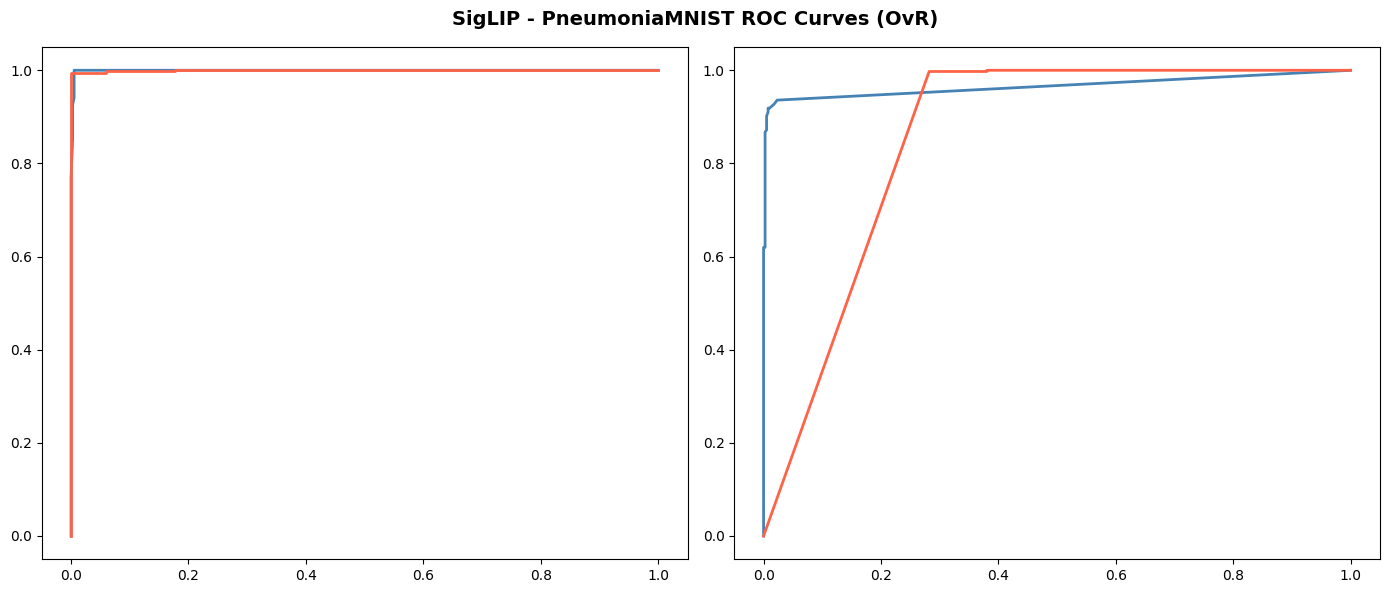

In [ ]:
palette = ["steelblue", "tomato"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("SigLIP - PneumoniaMNIST ROC Curves (OvR)", fontsize=14, fontweight="bold")
for ax, (probs, labels, title) in zip(axes, [
        (val_probs, val_labels, "Validation"),
        (tst_probs, tst_labels, "Test")]):

    lb = label_binarize(labels, classes=list(range(cfg.NUM_CLASSES)))

    # Fix for binary classification: label_binarize returns shape (n,1)
    if cfg.NUM_CLASSES == 2:
        lb = np.hstack([1 - lb, lb])  # make it (n, 2)

    for i, (cls, color) in enumerate(zip(cfg.CLASS_NAMES, palette)):
        fpr, tpr, _ = roc_curve(lb[:, i], probs[:, i])
        ax.plot(fpr, tpr, color=color, lw=2, label=f"{cls} (AUC={auc(fpr,tpr):.3f})")
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_pm_roc_curves.png"), dpi=150, bbox_inches="tight")
plt.show()


## Per-Class Metrics Comparison

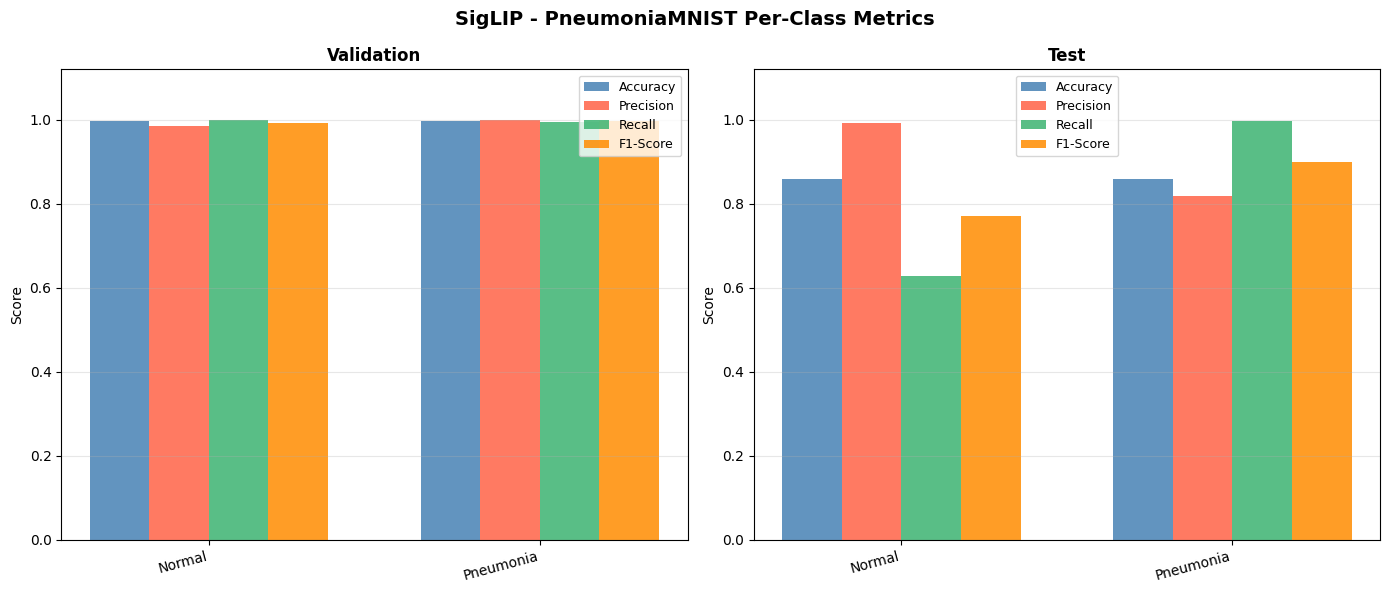

In [ ]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
mc = ["steelblue", "tomato", "mediumseagreen", "darkorange"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("SigLIP - PneumoniaMNIST Per-Class Metrics", fontsize=14, fontweight="bold")
for ax, split in zip(axes, ["Validation", "Test"]):
    sub = reports_df[reports_df["Split"] == split]
    x = np.arange(len(cfg.CLASS_NAMES)); w = 0.18
    for j, (met, col) in enumerate(zip(metrics, mc)):
        vals = [sub.loc[sub["Class"]==cls, met].values[0] for cls in cfg.CLASS_NAMES]
        ax.bar(x + j*w, vals, w, label=met, color=col, alpha=0.85)
    ax.set_xticks(x + w*1.5); ax.set_xticklabels(cfg.SHORT_NAMES, rotation=15, ha="right")
    ax.set_ylim(0, 1.12); ax.set_ylabel("Score")
    ax.set_title(split, fontsize=12, fontweight="bold")
    ax.legend(fontsize=9); ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, "siglip_pm_metrics_comparison.png"), dpi=150, bbox_inches="tight")
plt.show()


## Save & Summary

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "config": {"checkpoint": cfg.CHECKPOINT, "num_classes": cfg.NUM_CLASSES,
               "class_names": cfg.CLASS_NAMES, "img_size": cfg.IMG_SIZE},
    "best_val_loss": best_val_loss,
}, os.path.join(cfg.OUTPUT_DIR, "siglip_pm_final.pth"))

print("=" * 65)
print("DONE - SigLIP PneumoniaMNIST")
print("=" * 65)
print(f"  Best Val Loss  : {best_val_loss:.4f}")
print(f"  Val  Accuracy  : {val_acc:.4f}")
print(f"  Test Accuracy  : {tst_acc:.4f}")
print("\nPer-class F1 (Test):")
ts = reports_df[reports_df["Split"] == "Test"]
for _, r in ts.iterrows():
    print(f"  {r['Class']:20s} F1={r['F1-Score']:.4f}  Acc={r['Accuracy']:.4f}")
print("\nAll outputs saved.")


DONE - SigLIP PneumoniaMNIST
  Best Val Loss  : 0.0228
  Val  Accuracy  : 0.9962
  Test Accuracy  : 0.8590

Per-class F1 (Test):
  Normal               F1=0.7696  Acc=0.8590
  Pneumonia            F1=0.8984  Acc=0.8590

All outputs saved.
